   # HomeTask
   <img src="logo1.png">

In [ ]:
# Importing libraries
import math
import time
import datetime

import numpy as np
import pandas as pd

import logging

import seaborn as sns
from pprint import pprint
from math import sqrt
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.dates as mdates
import numpy

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [58]:
logging.basicConfig(level=logging.INFO)
try:
    df = pd.read_csv('../data/ml_eng_ay_data.csv.gz',parse_dates=['date']) # Importing the dataset
except OSError as e:
    logging.error("File not found")

In [59]:
df.head()

,date,cnt_rooms,flat_area,rent_base,rent_total,flat_type,flat_interior_quality,flat_condition,flat_age,flat_thermal_characteristic,has_elevator,has_balcony,has_garden,has_kitchen,has_guesttoilet,geo_city,geo_city_part
0,2018-09-15,1,36.00,530.0,650.0,apartment,average,good,60+,NaN,f,t,t,t,f,hamburg,wandsbek
1,2018-09-15,2,70.00,1100.0,1280.0,appartment,average,good,60+,NaN,t,t,f,t,f,hamburg,mitte
2,2018-09-15,2,62.13,1040.0,1220.0,apartment,sophisticated,first_time_use,<5,NaN,t,t,f,t,t,hamburg,altona
3,2018-09-15,2,75.00,675.0,950.0,roof_storey,average,good,<30,104.0,f,t,f,t,t,hamburg,wandsbek
4,2018-09-15,2,52.00,676.0,810.0,apartment,average,good,60+,NaN,f,t,f,t,f,hamburg,hamburg-nord


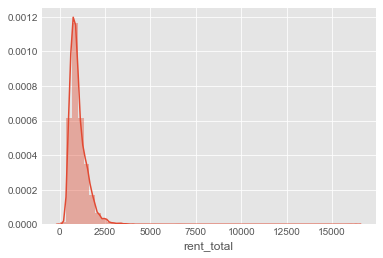

In [60]:
sns.distplot(df['rent_total']) # Checking the distribution of the target column

- We can see that the distribution of the column is skewed. This is due to the presence of some outliers. Lets check the outliers in the data.

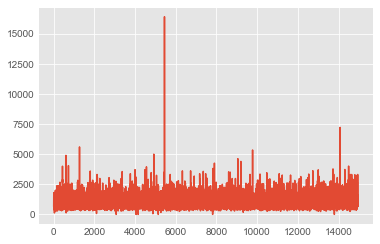

In [61]:
df.rent_total.plot(kind='line') # Plotting the target variable

- From the above plot we can see some of the outliers in the data.(Eg. There are few houses with prices abnormally higher like 15,000€,7500€ etc. and there are some houses with prices close to 100€ and most probably these prices are due to some fake ads). Let's see the box plot to see the quantile ranges and remove the outliers.

In [62]:
df = df.query('rent_total<4000 and rent_total>100') #Considering only prices between 100 and 4000.

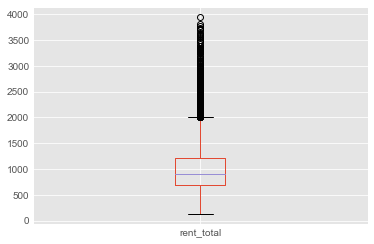

In [63]:
df.boxplot(column = ['rent_total']) # Box plot of the label

- From the above plot we can see some observations which are having less probability to occur from this distribution.

- If a data distribution is normal then about 68% of the data values lie within one standard deviation of the mean and about 95% are within two standard deviations, and about 99.7% lie within three standard deviations.Therefore, if you have any data point that is more than 3 times the standard deviation, then those points are very likely to be anomalous or outliers.

In [64]:
std_dev = df['rent_total'].std()  # Calculate standard deviation
mean = df['rent_total'].mean()   # Calculate mean of the variable
cutoff_val = mean + (3*std_dev)    # Finding the cutoff value

In [65]:
df = df[df['rent_total'] < cutoff_val] # Considering only values till 3 standard deviations

# Handling Missing values

In [66]:
df.isna().sum() / df.shape[0]  *100  # Checking for missing values

date                            0.00000
cnt_rooms                       0.00000
flat_area                       0.00000
rent_base                       0.00000
rent_total                      0.00000
flat_type                       0.00000
flat_interior_quality           0.00000
flat_condition                  0.00000
flat_age                        0.00000
flat_thermal_characteristic    32.49898
has_elevator                    0.00000
has_balcony                     0.00000
has_garden                      0.00000
has_kitchen                     0.00000
has_guesttoilet                 0.00000
geo_city                        0.00000
geo_city_part                   0.00000
dtype: float64

- Feature 'flat_thermal_characterstic' has almost 32% of the data points as missing values.

In [67]:
# Filling null values with median
df['flat_thermal_characteristic'].fillna(df['flat_thermal_characteristic'].median(), inplace=True) 

- I filled the null values with the median as it is a robust statistic. It won't be affected by outliers like mean.

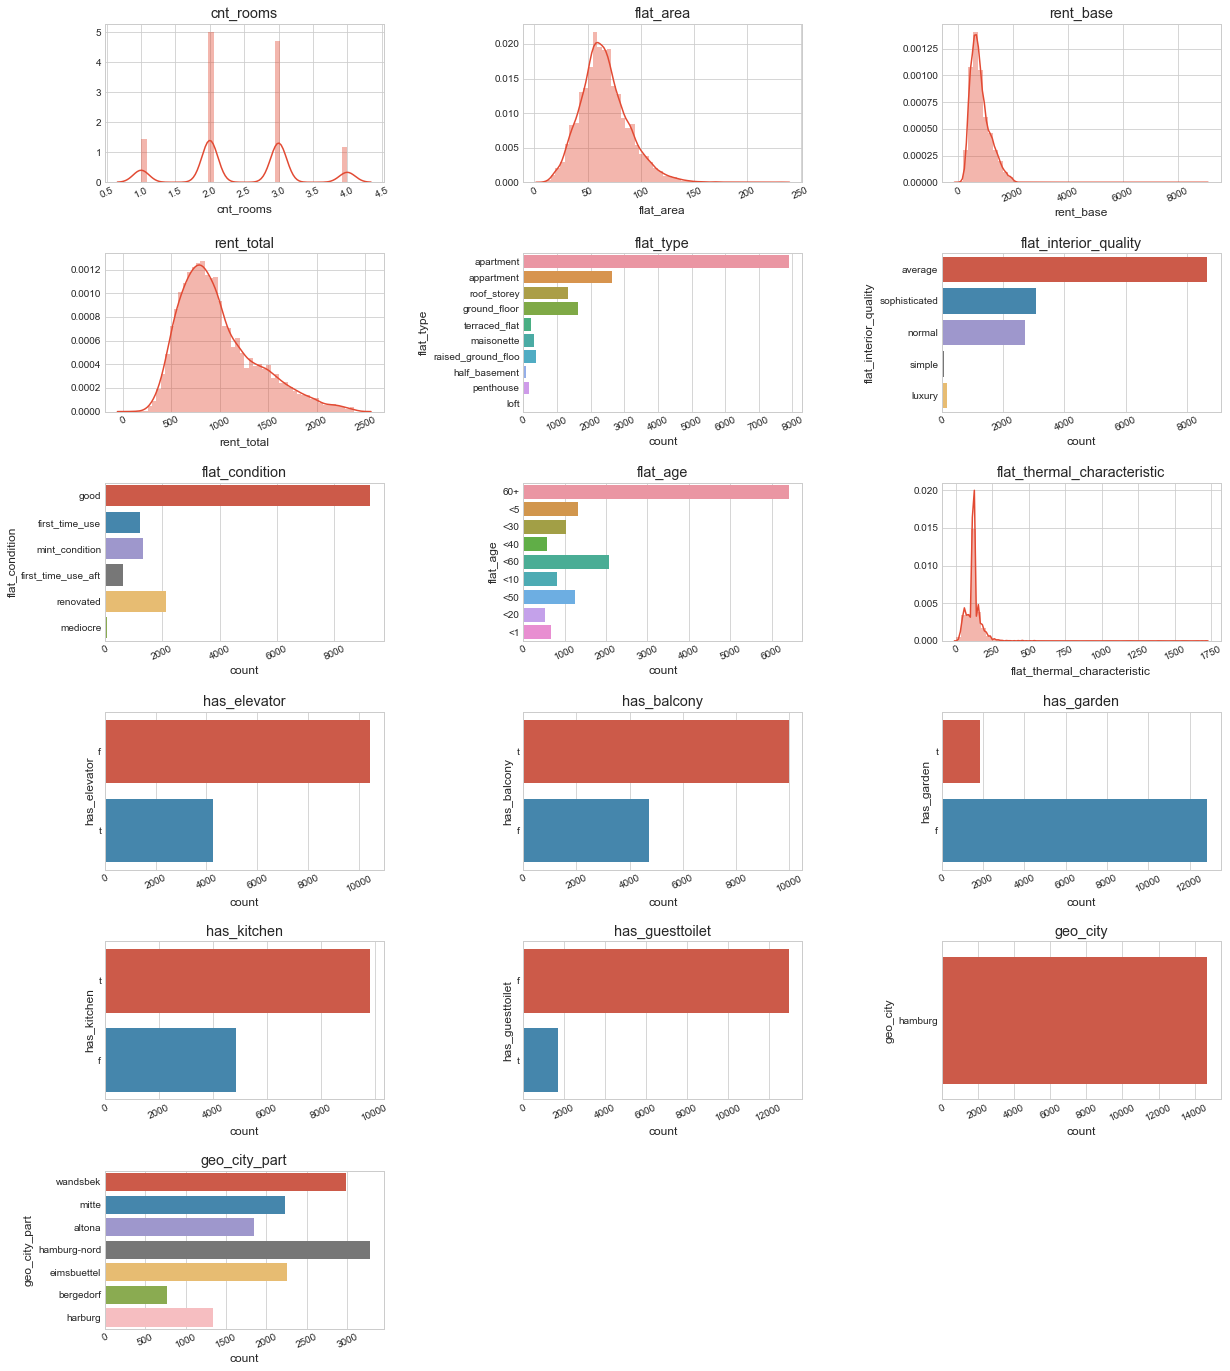

In [68]:
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    # Plotting the distribution of each of the features in the dataset
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        try:
            if dataset.dtypes[column] == np.object:    
                g = sns.countplot(y=column, data=dataset)
                substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
                g.set(yticklabels=substrings)
                plt.xticks(rotation=25)
            else:
                g = sns.distplot(dataset[column])
                plt.xticks(rotation=25)
        except:
            pass
    
plot_distribution(df.drop(['date'],axis=1), cols=3, width=20, height=24, hspace=0.45, wspace=0.5)

**Points to Note**

- From the above distribution we can observe that variance of the feature 'geo_city' is 0 and hence it can be ignored while model building. 

- Also, in the column 'flat_type' there are two values 'appartment' and 'apartment' representing the same type. Hence we can replace one of the type with the other.
- Many houses in Hamburg are old (60+).
- Most of the houses are apartments.
- Very few houses has gardens.
- Most of the houses has 2 or 3 rooms.

In [69]:
df.loc[df['flat_type'] == 'appartment', 'flat_type'] = 'apartment'  # Replacing type 'appartment' with 'apartment'
df.drop('geo_city',axis=1,inplace=True)   # Dropping the feature 'geo_city'

In [70]:
# Replacing the values 't' and 'f' values in the columns with 1 and 0. We can use label encoder also for this task.
df.loc[df['has_elevator'] == 't', 'has_elevator'] = 1
df.loc[df['has_elevator'] == 'f', 'has_elevator'] = 0
df.loc[df['has_garden'] == 't', 'has_garden'] = 1
df.loc[df['has_garden'] == 'f', 'has_garden'] = 0
df.loc[df['has_balcony'] == 't', 'has_balcony'] = 1
df.loc[df['has_balcony'] == 'f', 'has_balcony'] = 0
df.loc[df['has_kitchen'] == 't', 'has_kitchen'] = 1
df.loc[df['has_kitchen'] == 'f', 'has_kitchen'] = 0
df.loc[df['has_guesttoilet'] == 't', 'has_guesttoilet'] = 1
df.loc[df['has_guesttoilet'] == 'f', 'has_guesttoilet'] = 0

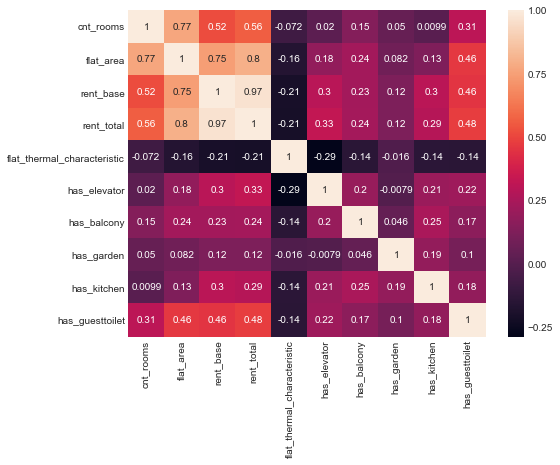

In [71]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(8,6))    # Defining the axis to plot the correlation matrix
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,annot=True)

 - From the above correlation matrix it's clear that rent_base is higly correlated to rent_total and hence we can ignore this feature while developing the model.

- Also, cnt_rooms and flat_area are highly correlated as it's normal that more number of rooms result in larger flat sizes. So we can ignore one of these features.




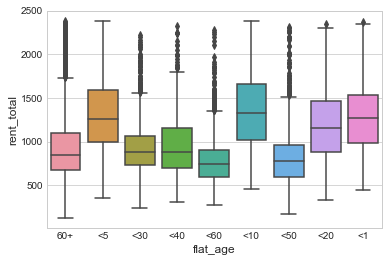

In [72]:
sns.boxplot(x='flat_age',y='rent_total',data=df)

 - From the above plots it's clear that new flats median price is higher than the older flats.

**Feature engineering**

Let's create some time related features which might impact the performance of the model.

In [73]:
# Extracting year,month,day and weekday from the date field
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['weekday'] = pd.DatetimeIndex(df['date']).weekday

In [74]:
df['is_weekend'] = df.apply(lambda row:1 if row['weekday'] >4 else 0,axis = 1)  #Checking whether the day is weekend or not.

- If the website is implementing some sort of dynamic pricing then on weekends prices might vary.Hence I c

In [75]:
df.head()

,date,cnt_rooms,flat_area,rent_base,rent_total,flat_type,flat_interior_quality,flat_condition,flat_age,flat_thermal_characteristic,...,has_balcony,has_garden,has_kitchen,has_guesttoilet,geo_city_part,year,month,day,weekday,is_weekend
0,2018-09-15,1,36.00,530.0,650.0,apartment,average,good,60+,119.8,...,1,1,1,0,wandsbek,2018,9,15,5,1
1,2018-09-15,2,70.00,1100.0,1280.0,apartment,average,good,60+,119.8,...,1,0,1,0,mitte,2018,9,15,5,1
2,2018-09-15,2,62.13,1040.0,1220.0,apartment,sophisticated,first_time_use,<5,119.8,...,1,0,1,1,altona,2018,9,15,5,1
3,2018-09-15,2,75.00,675.0,950.0,roof_storey,average,good,<30,104.0,...,1,0,1,1,wandsbek,2018,9,15,5,1
4,2018-09-15,2,52.00,676.0,810.0,apartment,average,good,60+,119.8,...,1,0,1,0,hamburg-nord,2018,9,15,5,1


In [76]:
def day_split(row):
    # Function that split the days to bins
    if row['day'] <= 10:
        return '1-10'
    elif row['day'] > 10 and row['day'] <= 20:
        return '11-20'
    else:
        return '21-31'

In [77]:
df['day_r'] = df.apply(day_split, axis = 1) # Creating a new feature by applying the above function on the data frame

In [78]:
df.head()

,date,cnt_rooms,flat_area,rent_base,rent_total,flat_type,flat_interior_quality,flat_condition,flat_age,flat_thermal_characteristic,...,has_garden,has_kitchen,has_guesttoilet,geo_city_part,year,month,day,weekday,is_weekend,day_r
0,2018-09-15,1,36.00,530.0,650.0,apartment,average,good,60+,119.8,...,1,1,0,wandsbek,2018,9,15,5,1,11-20
1,2018-09-15,2,70.00,1100.0,1280.0,apartment,average,good,60+,119.8,...,0,1,0,mitte,2018,9,15,5,1,11-20
2,2018-09-15,2,62.13,1040.0,1220.0,apartment,sophisticated,first_time_use,<5,119.8,...,0,1,1,altona,2018,9,15,5,1,11-20
3,2018-09-15,2,75.00,675.0,950.0,roof_storey,average,good,<30,104.0,...,0,1,1,wandsbek,2018,9,15,5,1,11-20
4,2018-09-15,2,52.00,676.0,810.0,apartment,average,good,60+,119.8,...,0,1,0,hamburg-nord,2018,9,15,5,1,11-20


# Handling the categorical data

In [79]:
# one hot encoding the categorical variables
one_hot_columns = ['flat_type','flat_interior_quality','flat_condition','flat_age','geo_city_part','day_r']   # Dropping the features which are note required for development of model and the target label
df_final = pd.get_dummies(df,columns=one_hot_columns,drop_first=True)

In [80]:
df_final.head()

,date,cnt_rooms,flat_area,rent_base,rent_total,flat_thermal_characteristic,has_elevator,has_balcony,has_garden,has_kitchen,...,flat_age_<50,flat_age_<60,geo_city_part_bergedorf,geo_city_part_eimsbuettel,geo_city_part_hamburg-nord,geo_city_part_harburg,geo_city_part_mitte,geo_city_part_wandsbek,day_r_11-20,day_r_21-31
0,2018-09-15,1,36.00,530.0,650.0,119.8,0,1,1,1,...,0,0,0,0,0,0,0,1,1,0
1,2018-09-15,2,70.00,1100.0,1280.0,119.8,1,1,0,1,...,0,0,0,0,0,0,1,0,1,0
2,2018-09-15,2,62.13,1040.0,1220.0,119.8,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0
3,2018-09-15,2,75.00,675.0,950.0,104.0,0,1,0,1,...,0,0,0,0,0,0,0,1,1,0
4,2018-09-15,2,52.00,676.0,810.0,119.8,0,1,0,1,...,0,0,0,0,1,0,0,0,1,0


In [81]:
X = df_final.drop(["date","rent_total","rent_base","month","year","day","weekday"],axis=1) # Splitting the features and label
y = df_final["rent_total"]

In [82]:
X_train,y_train = X[0:12000],y[0:12000] # Splitting the data into training and testing sets.
X_test,y_test = X[12000:],y[12000:] # Considering almost last 20% of the records as test set.

In [83]:
from sklearn.preprocessing import StandardScaler # Standardizing the features
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Model Building

**Naive Baseline model**

- A good default prediction for real values is to predict the central tendency. This could be the mean or the median. 
- A good default is to use the mean (also called the average) of the output value observed in the training data.

In [84]:
def baseline_model(train, test):
    # Defining a baseline model which returns mean as the predicted value
    output_values = [row for row in train]
    prediction = sum(output_values) / float(len(output_values))
    predicted = [prediction for i in range(len(test))]
    return predicted

In [85]:
from sklearn.metrics import mean_squared_error # Checking the root mean square value
y_pred = baseline_model(y_train.values,y_test)
rmse_val_baseline = np.sqrt(mean_squared_error(y_test,y_pred))

In [34]:
rmse_val_baseline

398.95331119255303

 - Baseline rmse is 392. Let's build some machine learning models to check if they can fit better than the baseline model

**Linear Regression**

In [35]:
from sklearn.linear_model import LinearRegression 
model_lr = LinearRegression()
model_lr.fit(X_train,y_train)   # Fitting the linear regression and checking the r2 value
model_lr.score(X_test,y_test)

0.7692487529806178

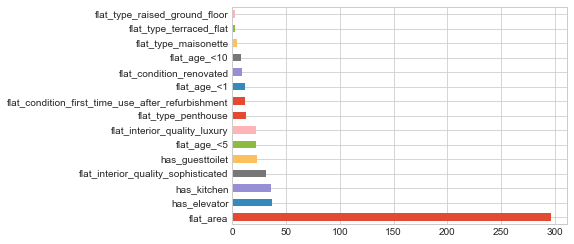

In [36]:
feat_coef = pd.Series(model_lr.coef_, index=X.columns) # Checking the feature coefficients
feat_coef.nlargest(15).plot(kind='barh')

- From the above plot it's clear that features like 'flat_area','has_kitchen','has_elevator','flat_interior_quality','flat_age' etc are playing significant role in deciding the cost of the rent.

In [37]:
from sklearn.metrics import mean_squared_error # Checking the root mean square value
y_pred = model_lr.predict(X_test)
rmse_val_lr = np.sqrt(mean_squared_error(y_test,y_pred))

In [38]:
rmse_val_lr

191.64047546505043

**Lasso Regression**

In [39]:
from sklearn.linear_model import Lasso # Fitting the lasso regression and checking the r2 value
model_las = Lasso(alpha = 10)
model_las.fit(X_train,y_train)
model_las.score(X_train,y_train)

0.7815385664325578

In [40]:
y_pred = model_las.predict(X_test) # Predicting the results and checking rmse value
rmse_val_las = np.sqrt(mean_squared_error(y_test,y_pred))
rmse_val_las

197.0042362746266

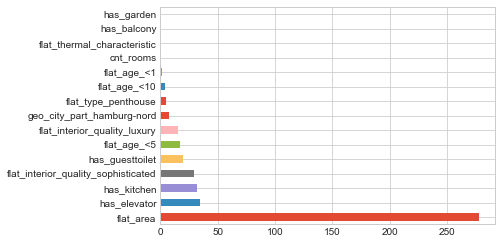

In [41]:
feat_coef = pd.Series(model_las.coef_, index=X.columns) # Plotting the feature coefficients
feat_coef.nlargest(15).plot(kind='barh')

- Lasso regression penalizes the values of the coefficients and hence they will be tending to zero.

**Random forest regression**

In [42]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators = 100,oob_score=True,max_depth=15,min_samples_split=10)

In [43]:
model_rf.fit(X_train,y_train) # Fitting the model
model_rf.score(X_test,y_test)

0.7920722381152125

In [44]:
model_rf.oob_score_   # Out of bag score

0.8281398120644652

In [45]:
y_pred = model_rf.predict(X_test)
rmse_val_rf = np.sqrt(mean_squared_error(y_test,y_pred))  # Checking the rmse value
rmse_val_rf

181.91623149919877

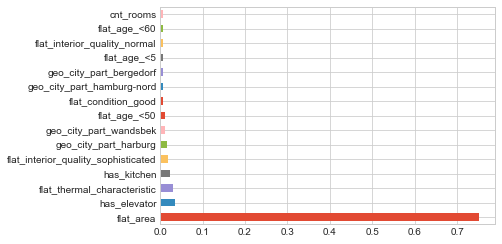

In [46]:
#plotting the feature importance
feat_importances = pd.Series(model_rf.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

**Support Vector Regression**

In [47]:
from sklearn.svm import SVR
model_svr = SVR(C = 10)

In [48]:
#fitting the model and checking the score
model_svr.fit(X_train,y_train)
model_svr.score(X_test,y_test)

0.6720384173670129

In [49]:
#checking the rmse value
y_pred = model_svr.predict(X_test)
rmse_val_svr = np.sqrt(mean_squared_error(y_test,y_pred))
rmse_val_svr

228.46869344683566

In [50]:
models = pd.DataFrame({
    'Model': ['Linear Regression', 
              'Lasso Regression', 'Random Forest', 
              'SVR'],
    'RMSE_Value': [
        rmse_val_lr, 
        rmse_val_las, 
        rmse_val_rf, 
        rmse_val_svr
    ]})
models.sort_values(by='RMSE_Value', ascending=True)

,Model,RMSE_Value
2,Random Forest,181.916231
0,Linear Regression,191.640475
1,Lasso Regression,197.004236
3,SVR,228.468693


- It is clear that ML models are better than the baseline model and among them  Random forest is performing better than the other models(As its RMSE is low). 

Now lets try to tune this model to improve the performance of it.

# Hyperparameter tuning

I have used random search to find the best parameters.

In [51]:
n_estimators = [100, 500, 800]
max_depth = [5, 15, 25]
min_samples_split = [2, 5, 15]
min_samples_leaf = [1, 2, 5] 

hyper_param = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(model_rf, hyper_param, cv = 3, verbose = 1, 
                      n_jobs = -1)
random_fit = random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.6min finished


In [52]:
model_rf_best = random_fit.best_estimator_  # Selecting the best model

In [53]:
random_fit.best_params_

{'n_estimators': 500,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': 25}

In [54]:
model_rf_best.fit(X_train,y_train)  # Fitting the data into the best model
model_rf_best.score(X_test,y_test)

0.7990729990603977

In [55]:
y_pred = model_rf_best.predict(X_test)
rmse_val_rf_new = np.sqrt(mean_squared_error(y_test,y_pred))  # Checking the rmse value
rmse_val_rf_new

178.82752352635111

In [56]:
logging.basicConfig(level=logging.INFO)
logging.info(rmse_val_rf_new)

- We can observe that the random search increased the performance slightly. However, if we increase the number of training points and further tune the model the performance can be increased even better.

Now let's deploy the model into the Docker  